# Laboratorio No.2 Redes Neuronales

## Andrés Urízar - 17632

In [1]:
import mnist_reader
import numpy as np
from scipy import optimize as op
from functools import reduce
X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')
#data = pd.read_csv('fashion-mnist_train.csv')

### Se procesa la información, en este caso normalizar los datos y obtener dimensiones

In [2]:
X = X_train/1000.0  #Normalizacion de los datos
m,n = X.shape # Para forma de las matrices
y = y_train.reshape(m,1)
Y = (y == np.array(range(10))).astype(int)

In [3]:
X.shape

(60000, 784)

In [12]:
Y.shape

(60000, 10)

### Se comienzan a realizar las funciones

#### (Se deben correr las funciones para probarlo)

#### Lista de matrices planas

In [4]:
flatten_list_of_arrays = lambda list_of_arrays: reduce(
    lambda acc, v: np.array([*acc.flatten(), *v.flatten()]),
    list_of_arrays
)    

#### Función para dar forma a matrices

In [5]:
def inflate_matrixes(flat_thetas, shapes):
    layers = len(shapes)+1
    sizes = [shape[0]*shape[1] for shape in shapes]
    steps = np.zeros(layers, dtype=int)
    
    for i in range(layers-1):
        steps[i+1]=steps[i]+sizes[i]
        
    return[
        flat_thetas[steps[i]: steps[i+1]].reshape(*shapes[i])
        for i in range(layers-1)
    ]

#### Lambda de función sigmoide

In [6]:
sigmoid = lambda z: 1.0/(1.0+np.exp(-z))

#### Forward propagation

In [8]:
#Forward propagation (lista de thetas, X=matrix(60000,784)) se realiza paso 2.1 y 2.2
def feed_propagation(thetas, X):
    a = [X] #Se guarda en la primera posicion el input en este caso X (paso 2.1)
    for i in range(len(thetas)): #Paso 2.2 para obtencion de matrices de activacion
        a.append(
            sigmoid(
                np.matmul(
                    np.hstack((np.ones(len(X)).reshape(len(X),1),a[i])),
                    thetas[i].T
                )
            )
        )
    return a

#### Back propagation

In [9]:
#Back propagation, se realizan pasos 2.3 y 2.4
def back_propagation(activate,lay,result,theta):
    deltas = [*range(lay-1), activate[-1]-result] #2.3 se calcula el error de la ultima capa y se almacena
    #2.4 se realiza el ciclo desde la penultima capa hasta la capa antes del inicio
    for i in range(lay-2,0,-1):
        #print(((np.delete(theta[i],0,1)).T).shape)
        #print(deltas[i+1].shape)
        #print((activate[i]*(1-activate[i])).shape)
        #deltas[i] = np.matmul((np.delete(theta[i],0,1)).T, deltas[i+1])*(activate[i]*(1-activate[i])) v.1.0
        deltas[i] = np.matmul(deltas[i+1],(np.delete(theta[i],0,1)))*(activate[i]*(1-activate[i])) #v2.0
    return deltas

In [10]:
#Se declaran las Deltas mayuscular con la forma de las Thetas, se hace paso 1
def deltaDeclaration(shape):
    delta = []
    for sh in shape:
        temp = np.zeros(sh, dtype=int)
        delta.append(temp)
    return delta

In [11]:
#Funcion de costo
def cost_function(flat_thetas, shapes, X, Y):
    activation_array = feed_propagation(
        inflate_matrixes(flat_thetas, shapes),
        X
    )

    return -(Y * np.log(activation_array[-1]) + (1 - Y) * np.log(1 - activation_array[-1])).sum() / len(X) 

#### Método para calculo de toda la predicción

In [12]:
def prediction_calculation(flat_thetas, shapes, X, Y):
    #Delta = deltaDeclaration(shapes)
        Deltaslist = [] #Paso 1
        m, layers = len(X), len(shapes)+1
        thetas = inflate_matrixes(flat_thetas,shapes)
        activation_array = feed_propagation(thetas,X) #Paso 2.2
        #deltas = back_propagation(activation_array,layers,Y,thetas)
        
        
        deltas = [*range(layers-1), activation_array[-1]-Y] #2.3
    #2.4 se realiza el ciclo desde la penultima capa hasta la capa antes del inicio
        for i in range(layers-2,0,-1):
            deltas[i] = np.matmul(deltas[i+1],(np.delete(thetas[i],0,1)))*(activation_array[i]*(1-activation_array[i]))
            
        #2.5 v1.0
#         for i in range(layers-1):
#             a,b = thetas[i].shape
#             Delta = np.zeros(a*b).reshape(a,b)
#             x, _ = activation_array[i].shape
#             for j in range(x):
#                 Delta = Delta + np.matmul(((deltas[i+1][j]).reshape(len(deltas[i + 1][j]),1)),
#                 ((np.append([1],activation_array[i][j])).reshape(len(activation_array[i][j])+1,1)).T)
            
#             Deltas.append(Delta)
        
#         Deltas = np.asarray(Deltas)

#         return flatten_list_of_arrays([
#             np.true_divide(d,m)
#             for d in Deltas
#         ])
        # Paso 2.5 v2.0
        for i in range(layers-1):
            Deltaslist.append(
                (
                    np.matmul(
                        deltas[i+1].T,
                        np.hstack((
                            np.ones(len(activation_array[i])).reshape(len(activation_array[i]),1),
                            activation_array[i])))
                )/m #Paso 3
            )
        Deltaslist = np.asarray(Deltaslist)
        
        return flatten_list_of_arrays(Deltaslist)

### Se realiza la arquitectura de las matrices de la red neuronal

In [13]:
REDES = np.array([
        n,
        125,
        10
    ])
# una sola capa de 125 neuronas
theta_shapes = np.hstack((
    REDES[1:].reshape(len(REDES)-1, 1),
    (REDES[:-1]+1).reshape(len(REDES)-1,1)
))


flat_thetas = flatten_list_of_arrays([
    np.random.rand(*theta_shape)*0.01 
    for theta_shape in theta_shapes
])

## Ya no corre el siguiente método porque es el que realiza el cálculo de thetas

### Desarrollo de red neuronal

In [86]:
print("\n---------------- OPTIMIZING ----------------\n")
result = op.minimize(
    fun = cost_function,
    x0 = flat_thetas,
    args = (theta_shapes, X, Y),
    method = 'L-BFGS-B',
    jac = prediction_calculation,
    options = {'disp': True, 'maxiter': 3000}
)
print("\n---------------- OPTIMIZED ----------------\n")



---------------- OPTIMIZING ----------------



<ipython-input-82-f3f1e6bf45b6>:8: RuntimeWarning: divide by zero encountered in log
  return -(Y * np.log(activation_array[-1]) + (1 - Y) * np.log(1 - activation_array[-1])).sum() / len(X)
<ipython-input-82-f3f1e6bf45b6>:8: RuntimeWarning: invalid value encountered in multiply
  return -(Y * np.log(activation_array[-1]) + (1 - Y) * np.log(1 - activation_array[-1])).sum() / len(X)



---------------- OPTIMIZED ----------------



In [161]:
# Se guarda el resultado de thetas optimizadas
np.savetxt('thetas_optimized3.txt', result.x,delimiter=',')

In [160]:
result.x.size

99385

#### Muestra de los resultados

In [144]:
result

      fun: nan
 hess_inv: <99385x99385 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.31761763e-08,  3.86480649e-15,  2.96099077e-15, ...,
       -1.00984083e-15,  1.93395179e-07, -5.79911462e-08])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 12103
      nit: 1687
   status: 0
  success: True
        x: array([-3.80816181e-01,  4.05849884e-03,  8.14810819e-03, ...,
        1.37269472e+00, -1.84523917e+01,  3.31388030e-01])

## Test de thetas

In [14]:
thetaResult = np.loadtxt('thetas_optimized3.txt') # se carga la theta de un txt
thetaResult.size

99385

#### Normalización de datos de prueba

In [15]:
X_test = X_test/1000
mT,nT = X_test.shape
y_test = y_test.reshape(mT,1)

In [16]:
flat_thetas_result = thetaResult

In [21]:
inflate_thetas_result = inflate_matrixes(flat_thetas_result, theta_shapes)
a_result = feed_propagation(inflate_thetas_result, X_test)

In [27]:
maximos = np.argmax(a_result[-1], axis = 1)
accuracy = 0
for i in range(len(a_result[-1])):
    if(maximos[i] == y_test[i][0]):
        accuracy += 1
success = accuracy*100/len(a_result[-1])
failure = 100.0 - success
print("Porcentaje de éxito: ", success)
print("Porcentaje de fallo: ", failure)

Porcentaje de éxito:  86.71
Porcentaje de fallo:  13.290000000000006


## Análisis sobre hallazgos

El modelo ha obtenido un valor de 86.71% de éxito, lo cuál indica que fue un valor muy elevado. Solamente se utilizó una capa oculta, y en ella habian 125 neuronas. No se utilizó otra capa, debido que se nos fue mencionado que no habría que agregar tanta complejidad al modelo por lo cuál decidi dejarlo solamente en una capa, y tampoco hay overfitting.
Por resultados en la sección Visualización de imágenes, se vio que es un éxito al demostrar al atinarle a las diferentes imágenes.
Quizá el resultado del porcentaje de la predicción hubiera mejorado si hubiera puesto más neuronas en la capa oculta, quizá hubiera causada un efecto positivo, pero por lo mismo que no queria complicar el modelo, se quedo en 125.

## Visualización de imágenes

In [34]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

In [40]:
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')
y_test = np.asarray(y_test).reshape(X_test.shape[0], 1)

In [38]:
mnist = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

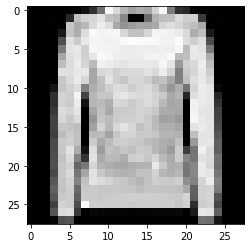

Predicho: Pullover
Real: Pullover

1. Mostrar siguiente imagen
2. Salir.
1


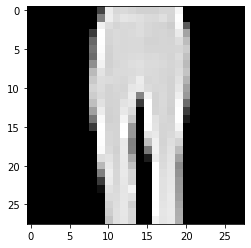

Predicho: Trouser
Real: Trouser

1. Mostrar siguiente imagen
2. Salir.
1


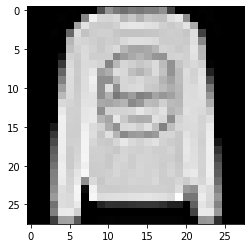

Predicho: Pullover
Real: Pullover

1. Mostrar siguiente imagen
2. Salir.
2


In [41]:
op = 0
nums = []

# and cont < len(a[-1])

while op != "2":
    num = random.randint(0, len(a[-1]))
    while num in nums:
        nums.append(num)
        
    #pixels = listToMatrix(x_test.values[num], 28)
    pixels = np.asarray([(x,x,x) for x in X_test[num]]).reshape(28,28,3)
    # Convert the pixels into an array using numpy
    array = np.array(pixels, dtype=np.uint8)

    # Use PIL to create an image from the new array of pixels
    new_image = Image.fromarray(array)
    new_image.save('test.png')
    
    img = mpimg.imread('test.png')
    imgplot = plt.imshow(img)
    
    plt.show()
    print("Predicho: " + mnist[maximos[num]])
    print("Real: " + mnist[y_test[num][0]])
    
#     cont += 1
    
    op = input("\n1. Mostrar siguiente imagen\n2. Salir.\n")